<b>The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.</b>

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as pt
from sklearn import cross_validation, metrics
import sklearn
import warnings
warnings.filterwarnings('ignore')


In [4]:
train = pd.read_csv("/Users/virajdattkohir/Downloads/Train_UWu5bXk.csv")
test = pd.read_csv("/Users/virajdattkohir/Downloads/Test_u94Q5KV.csv")

In [5]:
train.head(5)
test.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


Its always better to combine the traing and test set so as to do some feature Engg and again split it later.
Here we will create a column both in the training and test data set, to know the source and later combine it 
into a single set known as <b>data</b>.

<b>pd.concat</b> : Concatenate pandas objects along a particular axis with optional set logic along the other axes.
            Clear the existing index and reset it in the result by setting the ignore_index option to True.

In [6]:
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train,test],ignore_index=True)
print(train.shape, test.shape, data.shape)

(8523, 13) (5681, 12) (14204, 13)


First we will look into the first five entries of the training data

In [7]:
train.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


For few details step on how to do data exploration follow the following link 
https://www.analyticsvidhya.com/blog/2016/01/12-pandas-techniques-python-data-manipulation/

## DATA EXPLORATION :
This is an important step in any analysis, here we look at the data to 
1.Identify outliers
2.Identify missing values
3.Learn a few stats about the variables or predictors 
4.

### HANDLING THE MISSING VALUES :<br>
 We use the apply and lamda function to do look into those entiers which have missing values.

In [8]:
data.apply(lambda x:sum(x.isnull()))

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

#### Item_Outlet_Sales            5681 --> Missing values from the TEST set (can be ignored)
#### Actually missing : <br>
    1. Item_Weight  2439 
    2. Outlet_Size  4016



Now lets look at some stats of the numerical variables in our dataset

In [9]:
data.describe()


,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


Item_Visibility has a min value of zero. My interpretation on this is that some of the products are kept in shevles covered by some other products and are not visible, quite often older products are not managed well and may end up being invisible. The lower ‘count’ of Item_Weight and Item_Outlet_Sales confirms the findings from the missing value check.

In [10]:
data.apply(lambda x: len(x.unique()))


Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
source                           2
dtype: int64

This tells us that there are 1559 products and 10 outlets/stores (which was also mentioned in problem statement). Another thing that should catch attention is that Item_Type has 16 unique values. <br>Let’s explore further using the frequency of different categories in each nominal variable. I’ll exclude the ID and source variables for obvious reasons.<br>

<b>value_counts:</b>(normalize=False, sort=True, ascending=False, bins=None, dropna=True)[source]
Returns object containing counts of unique values.

The resulting object will be in descending order so that the first element is the most frequently-occurring element. Excludes NA values by default.

In [11]:
#Filtering the categorical variables
cat_var = [x for x in data.dtypes.index if data.dtypes[x] == 'object']
#Exclude ID cols and source:
categorical_columns = [x for x in cat_var if x not in ['Item_Identifier','Outlet_Identifier','source']]
#Print frequency of categories
for col in categorical_columns:
    print('\nFrequency of Categories for varible %s'%col)
    print(data[col].value_counts())



Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

F

Observations from above : <br>

1. <bold>Item_Fat_Content<bold> : <br>It has 2 levels low fat and regular, but the data is not uniformily coded as we see there are some typos like Low fat being coded as LF<br>

2. Item_Type : <br>Here we can combine a few Item types as a few observations have relatively less frequency<br>

## Data Cleaning

Lets impute the missing values for Item_Weight and Outlet_Size <br>

For the Item_Weight we impute the average value of Item_Weight(Naive Approcah)<br>





Lets look into the distrubution of the Outlet_Size from the data at hand.

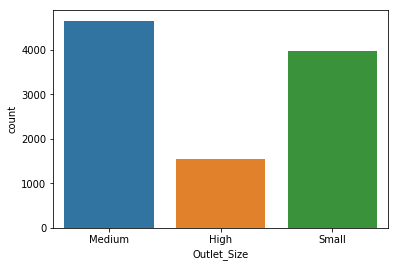

In [12]:
import seaborn as sns
sns.countplot(x = "Outlet_Size", data = data )
pt.show()

For the Outlet_Size we impute the value "Meduim" since it is the most recurring value. This is a navie approach other alternatives can be used such as imputing the value based on the Outlet_Location.


In [13]:
#Fill the na in Outlet_Size column with the value Medium
data["Outlet_Size"].fillna("Medium", inplace = True)


In [14]:
#Fill na in the Item_Weight with the mean of Item_Weight.
data["Item_Weight"].fillna(data["Item_Weight"].mean(),inplace = True)
data.apply(lambda x:sum(x.isnull()))

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                     0
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                     0
Outlet_Type                     0
source                          0
dtype: int64

## Feature Engg <br>
#### Here we will create new features which will help us in buliding the model

Now here we create a new variable called, Outlet Years, this is the number of years for which the shop has been running.

In [15]:
#Years:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

#### Now as we have seen there were some typos in the fat category, so we correct those and make the neccasary changes to fix the typos<br>

<b>pd.replace</b>(to_replace=None, value=None, inplace=False, limit=None, regex=False, method='pad', axis=None)[source]<br>
     Replace values given in ‘to_replace’ with ‘value’.

In [16]:
#Change categories of low fat:
print('Original Categories:')
print(data['Item_Fat_Content'].value_counts())

print('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'})
print(data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [313]:
datab['Item_Identifier']=datab['Item_Identifier'].astype(str)

## Create a broad category of Type of Item
Earlier we saw that the Item_Type variable has 16 categories which might prove to be very useful in analysis. So its a good idea to combine them. One way could be to manually assign a new category to each. But there’s a catch here. If you look at the Item_Identifier, i.e. the unique ID of each item, it starts with either FD, DR or NC. If you see the categories, these look like being Food, Drinks and Non-Consumables. So I’ve used the Item_Identifier variable to create a new column:

In [17]:
#Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

Now it makes more sense. But above we saw there were some non-consumables as well and a fat-content should not be specified for them. So we can also create a separate category for such kind of observations. <br>

## df.loc[index,column_name]


In [18]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

Since scikit-learn accepts only numerical variables,  convert all categories of nominal variables into numeric types. Also, we want Outlet_Identifier as a variable as well. So we create a new variable ‘Outlet’ same as Outlet_Identifier and coded that. Outlet_Identifier should remain as it is, because it will be required in the submission file.

Lets start with coding all categorical variables as numeric using ‘LabelEncoder’ from sklearn’s preprocessing module.

In [19]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

One-Hot-Coding refers to creating dummy variables, one for each category of a categorical variable. For example, the Item_Fat_Content has 3 categories – ‘Low Fat’, ‘Regular’ and ‘Non-Edible’. One hot coding will remove this variable and generate 3 new variables. Each will have binary numbers – 0 (if the category is not present) and 1(if category is present). This can be done using ‘get_dummies’ function of Pandas.

In [20]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type','Item_Type_Combined','Outlet'])

In [21]:
data.dtypes


Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
source                        object
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
Outlet_0                       uint8
O

Here we can see that all variables are now float and each category has a new variable. Lets look at the 3 columns formed from Item_Fat_Content.



In [22]:
data[['Item_Fat_Content_0','Item_Fat_Content_1','Item_Fat_Content_2']].head(10)


,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0
5,0,0,1
6,0,0,1
7,1,0,0
8,0,0,1
9,0,0,1


Final step is to convert data back into train and test data sets. Its generally a good idea to export both of these as modified data sets so that they can be re-used for multiple sessions. This can be achieved using following code:

In [23]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

## MODEL BULIDING

Lets define a generic function which takes the algorithm and data as input and builds a model, performs cross-validation and generates submission. iD columns are needed in the submission file.

In [24]:
#Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
from sklearn import cross_validation, metrics
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
#Fit takes two argument, 1. A list of predictors; 2. A list/array of target values.(in this case theItem_Outlet_Sales )
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
     #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)


Here above the module is evaluated based on its RMSE, a standard way to measure the model performance for a regresion problem. Its the average differnce between the actual value and the predicted value.<br> 

The Lesser the value of RMSE the better is the prediction. <br>

<b>sklearn.metrics.mean_squared_error</b>(y_true, y_pred, sample_weight=None, multioutput=’uniform_average’)<br>
 y_true : array-like of shape = (n_samples) or (n_samples, n_outputs) :Ground truth (correct) target values.

y_pred : array-like of shape = (n_samples) or (n_samples, n_outputs): Estimated target values.

## ALGORITHMS BEING USED  

#### Differnt algorithms are used and models are evaluated based on the RMSE obtained from each candidate model. The model that performs the best is used as the final model.

1. LINEAR REGRESSION :- <br>

2. RIDGE REGRESSION :- <br>

2. CART REGRESSION TREE :- <br>

3. RANDOM FOREST :- <br>




Model Report
RMSE : 1127
CV Score : Mean - 1128 | Std - 43.61 | Min - 1075 | Max - 1211


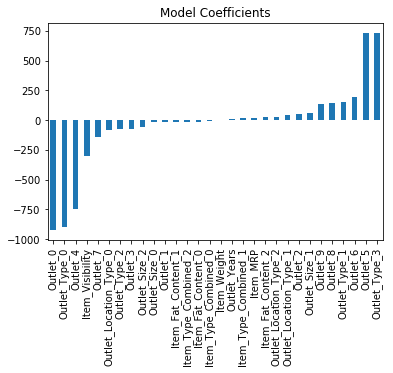

In [25]:
#LINEAR REGRESSION :-
from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [target]+IDcol]
# print predictors
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train, test, predictors, target, IDcol, 'alg1.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')
pt.show()


Model Report
RMSE : 1128
CV Score : Mean - 1130 | Std - 44.81 | Min - 1076 | Max - 1218


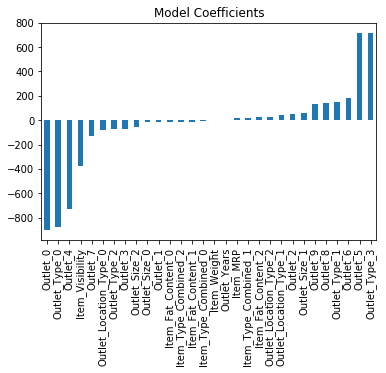

In [26]:
#RIDGE REGRESSION :- 
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2, train, test, predictors, target, IDcol, 'alg2.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')
pt.show()


Model Report
RMSE : 1059
CV Score : Mean - 1092 | Std - 45.05 | Min - 1016 | Max - 1180


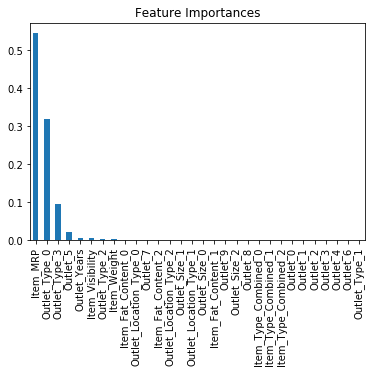

In [27]:
#CART REGRESSION :- 
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train, test, predictors, target, IDcol, 'alg3.csv')
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')
pt.show()


Model Report
RMSE : 1071
CV Score : Mean - 1096 | Std - 43.3 | Min - 1027 | Max - 1172


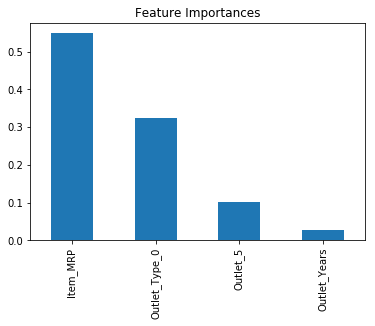

In [46]:
#CART REGRESSION :- #(With less number of features and reducing the depth of tree to avoid overfitting)
predictors = ['Item_MRP','Outlet_Type_0','Outlet_5','Outlet_Years']
alg4 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
modelfit(alg4, train, test, predictors, target, IDcol, 'alg4.csv')
coef4 = pd.Series(alg4.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')
pt.show()


Model Report
RMSE : 1074
CV Score : Mean - 1083 | Std - 43.93 | Min - 1020 | Max - 1161


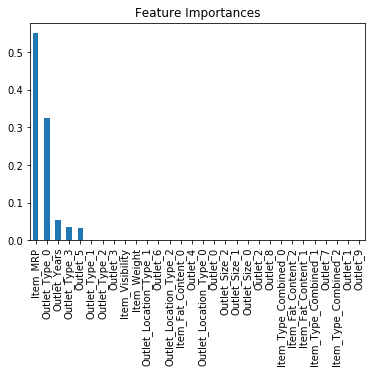

In [29]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg5, train, test, predictors, target, IDcol, 'alg5.csv')
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')
pt.show()

From the various candidate models we can conclude that the CART tree named alg3 performs better. These models can be further tuned using GBM & XGBoost. We can also vizualize the CART tree and view the splitting rules that is being generated.